# MNIST Hand Written Digits Prediction

In [1]:
# Importing the dependencies
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [3]:
# loading the dataset of mnist from tensorflow
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# There are 60K rows with images of (28,28) grid in training data
X_train.shape

(60000, 28, 28)

In [5]:
# There are 10K rows with images of (28,28) grid in testing data
X_test.shape

(10000, 28, 28)

In [5]:
# Total number of classes in the Data
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
# Making the dataframe for the train for
X_train_flat = X_train.reshape(X_train.shape[0],-1)
df = pd.DataFrame(X_train_flat)
df['y'] = y_train
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


<Axes: xlabel='y', ylabel='count'>

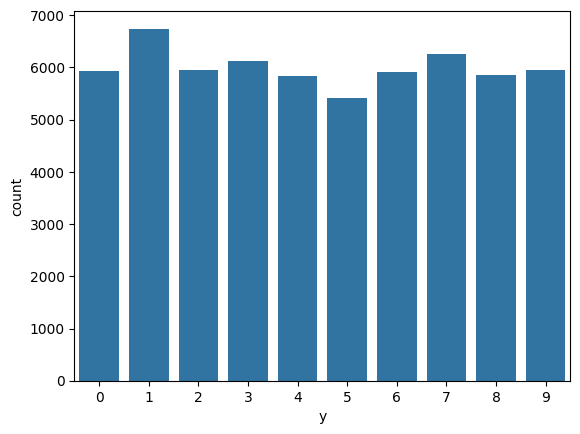

In [9]:
# data for most part is consistent, not a significant difference in no. of samples from each class
sns.barplot(df['y'].value_counts())

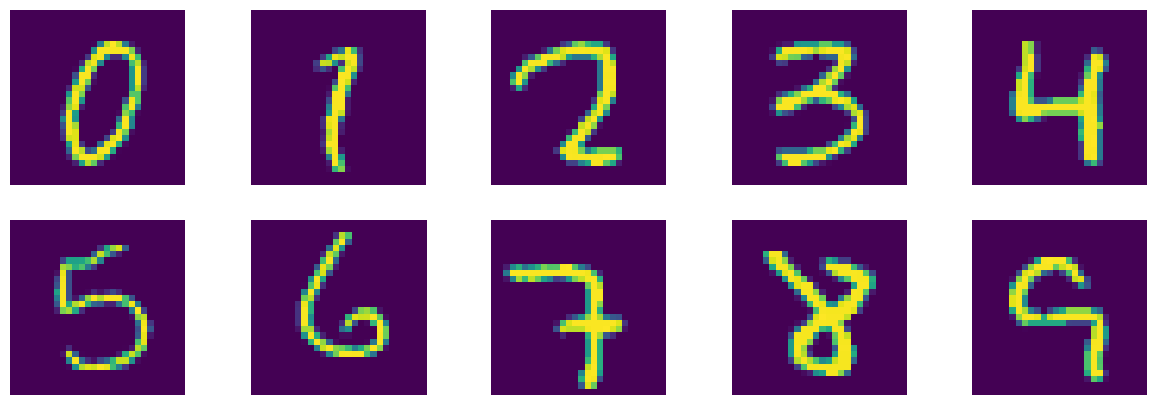

In [8]:
# visualizing the digits
plt.figure(figsize=(15,5))
for i in np.unique(y_train):
  plt.subplot(2,5,i+1)
  rand = random.randint(0,100)
  row = np.array(df[df['y']==i].iloc[rand-1:rand,:-1]).reshape(28,28)
  plt.imshow(row)
  plt.axis('off')

# Image Augmentation

In [9]:
# Creating distortion, rotation, stretching, etc is called data augmentation
aug_data = ImageDataGenerator(
                    rotation_range= 10,
                    zoom_range= 0.10,
                    width_shift_range=0.1,
                    height_shift_range= 0.1,
                )

# Model Building
### We are using CNN a convolution neural networks spcially designed for identifying and classifying images

In [10]:
# Normalizing images that are from 0-255 to 0-1
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255

In [18]:
# CNN model with regularization and batch normalization and dropout to reduce overfitting
# The total parameters we are training is 300K
nets = 15

model = [0] * nets

for i in range(nets):
    model[i] = Sequential()
    
    model[i].add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1))) 
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size=3, activation='relu')) 
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size=5, activation='relu', strides=2, padding='same')) 
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))
    
    model[i].add(Conv2D(64, kernel_size=3, activation='relu')) 
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size=3, activation='relu')) 
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size=5, activation='relu', strides=2, padding='same')) 
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))
    
    model[i].add(Conv2D(128, kernel_size=3, activation='relu')) 
    model[i].add(BatchNormalization())
    
    model[i].add(Flatten())
    model[i].add(Dropout(0.4))
    
    model[i].add(Dense(120, activation='relu'))
    model[i].add(Dense(60, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))

    model[i].compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

## Training on 15 different models with data augmentation applied for 45 epochs means by calculation I am training on approximately roughly 38 million images.

In [197]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x) # used to regulate the learning rate for each epoch to help my model to reach minima.
epochs = 45
history = [0] * nets
for i in range(nets):
    
    X2_train, X2_test, y2_train, y2_test  = train_test_split(X_train, y_train, test_size=0.1)
    
    history[i] = model[i].fit(aug_data.flow(X2_train, y2_train, batch_size=64),
                epochs = epochs, steps_per_epoch=X2_train.shape[0]//64,  
                validation_data = (X2_test, y2_test), callbacks=[annealer], verbose=0)
    
    print(f"CNN={i+1}, train_accuracy={history[i].history['accuracy'][-1]}, val_accuracy={history[i].history['val_accuracy'][-1]}") # printing each model status

CNN=1, train_accuracy=0.9981644749641418, val_accuracy=0.9965000152587891
CNN=2, train_accuracy=0.9975897073745728, val_accuracy=0.9963333606719971
CNN=3, train_accuracy=0.9977009892463684, val_accuracy=0.9958333373069763
CNN=4, train_accuracy=0.997775137424469, val_accuracy=0.9971666932106018
CNN=5, train_accuracy=0.9977009892463684, val_accuracy=0.9971666932106018
CNN=6, train_accuracy=0.997645378112793, val_accuracy=0.996666669845581
CNN=7, train_accuracy=0.9975526332855225, val_accuracy=0.9975000023841858
CNN=8, train_accuracy=0.9974784851074219, val_accuracy=0.9978333115577698
CNN=9, train_accuracy=0.9978122115135193, val_accuracy=0.9978333115577698
CNN=10, train_accuracy=0.9974043369293213, val_accuracy=0.9973333477973938
CNN=11, train_accuracy=0.9973116517066956, val_accuracy=0.9961666464805603
CNN=12, train_accuracy=0.9976083040237427, val_accuracy=0.9978333115577698
CNN=13, train_accuracy=0.9977195262908936, val_accuracy=0.996999979019165
CNN=14, train_accuracy=0.9974970221519

In [96]:
# Saving the model so I don't have to retrain the model
j = 1
for i in model:
    i.save(f'model{j}.h5')
    j = j+1

In [48]:
# loading the saved models
model = [0] * nets
for i in range(nets):
    model[i] = load_model(f'model{i+1}.h5')

# Evaluation

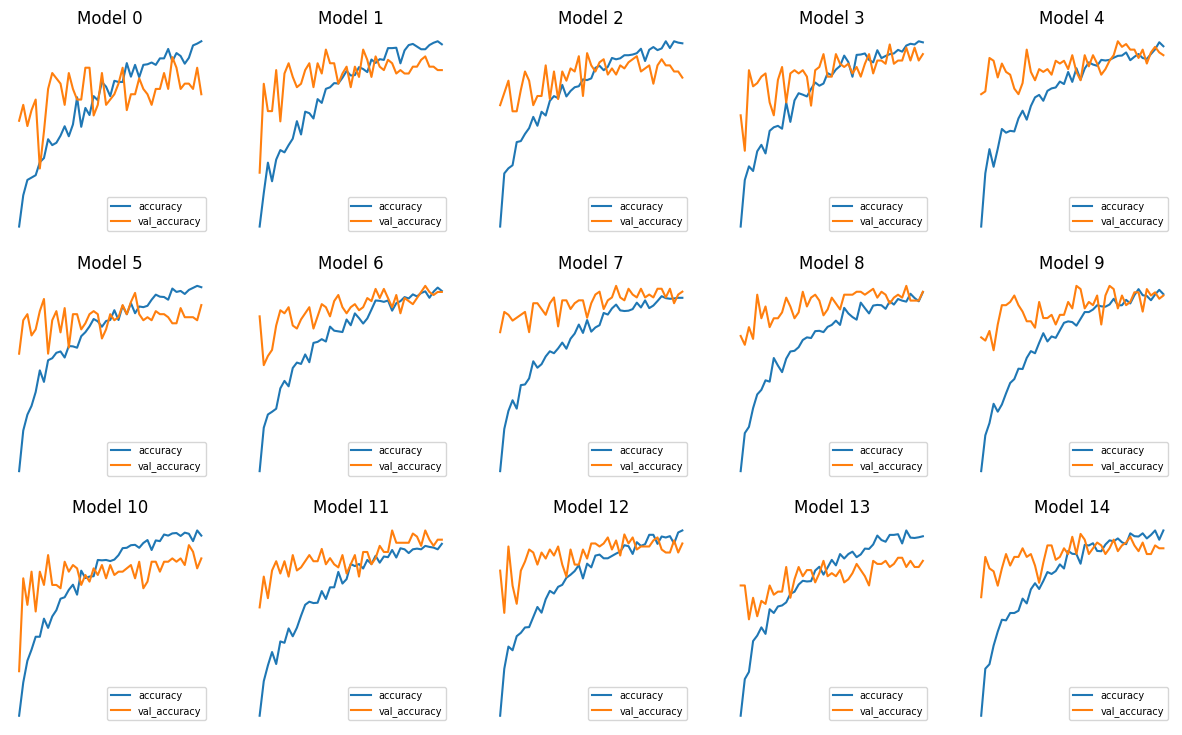

In [212]:
# These are 15 models that train and test accuracy alongside it. Although some models might be a little overfitting when the testing line deviates from 
# training line but as we are training 15 different models this means we can use "Wisdom of the Crowd" as the approach to eliminate overfitting
plt.figure(figsize=(15,9))
for i in range(nets):
    plt.subplot(3,5,i+1)
    plt.plot(history[i].history['accuracy'], label='accuracy')
    plt.plot(history[i].history['val_accuracy'], label='val_accuracy')
    plt.title(f"Model {i}")
    plt.axis('off')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right', prop={'size': 7})

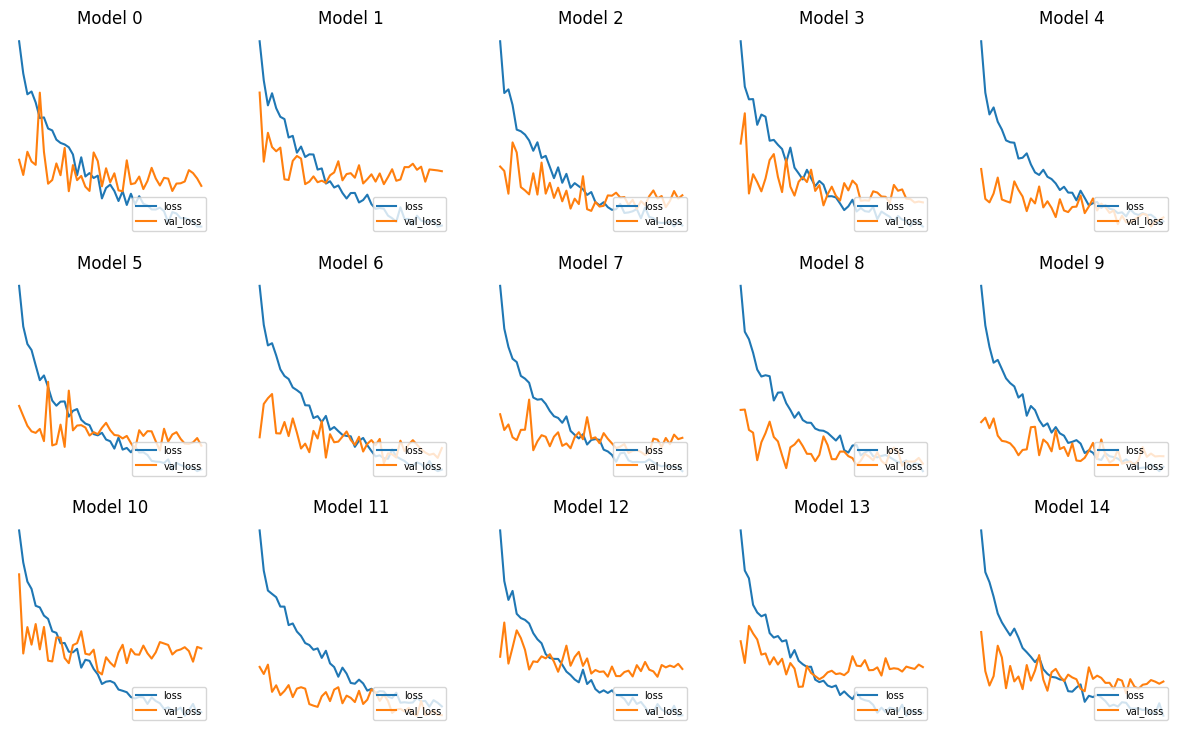

In [213]:
# Here is loss accuracy
plt.figure(figsize=(15,9))
for i in range(nets):
    plt.subplot(3,5,i+1)
    plt.plot(history[i].history['loss'], label='loss')
    plt.plot(history[i].history['val_loss'], label='val_loss')
    plt.title(f"Model {i}")
    plt.axis('off')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right', prop={'size': 7})

# Testing 

In [128]:
# Taking ensemble to model to give 10 predictions where I then use it to plot graphs for testing
y_pred = np.zeros( (X_test.shape[0],10) )
for i in range(nets):
    y_pred = y_pred + model[i].predict(X_test, verbose=0)
y_pred = y_pred.argmax(axis=1)
y_pred = pd.Series(y_pred)

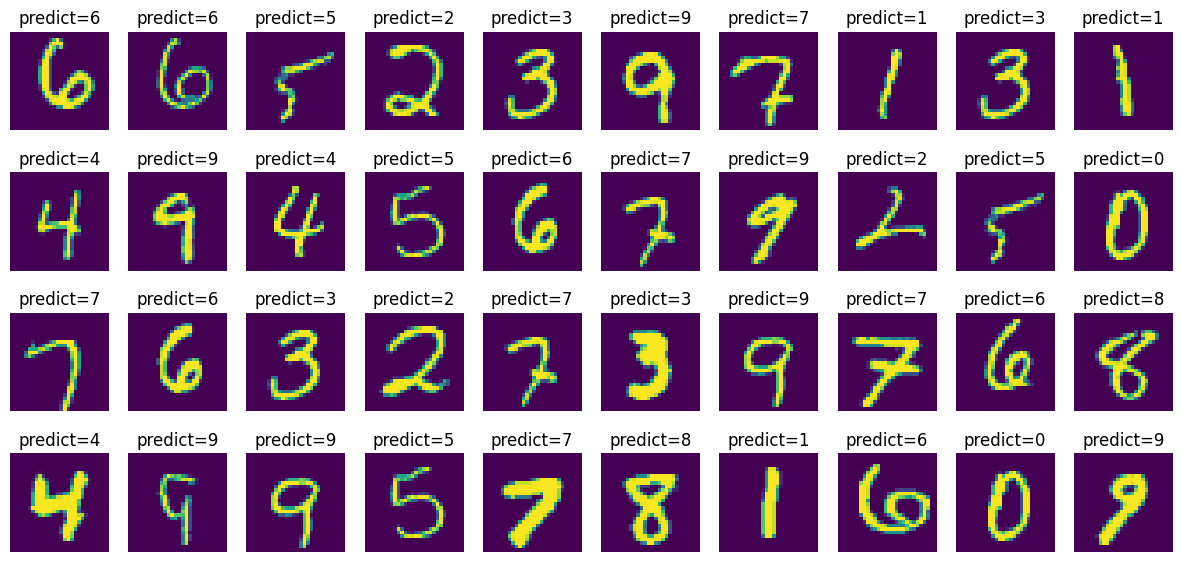

In [129]:
# Graphs and their prediction 
plt.figure(figsize=(15,7))
for i in range(40):
    plt.subplot(4,10,i+1)
    rand= random.randint(0,100)
    plt.imshow(X_test[i+rand].reshape(28,28))
    plt.title(f"predict={y_pred[i+rand]}",y=1)
    plt.axis('off')